<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Mounted at /gdrive


In [19]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-ebd7de9d04f3>", line 1, in <module>
    get_ipython().magic('cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport endpoint is not connected


OSError: ignored

In [0]:
import pandas as pd
df = pd.read_csv("data/final_data.csv", index_col = 0, parse_dates = True)

In [0]:
df = df[df.index > "2016-06-02"]
df['density'] = (df.flow * 60) / df.speed

In [0]:
cols = ["speed", "flow", "density", "speed_limit", "holiday", "weekend"]
continuous_cols = ["speed", "flow", "density"]
discrete_cols = ["speed_limit", "holiday", "weekend"]
df = df[cols]

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "15T"):
    r_df = df.copy()
    r_df = r_df.resample(freq).agg({
           "speed": np.mean, "flow": np.sum, "density": np.mean, "speed_limit": np.median, "holiday": np.median, "weekend": np.median})
    return r_df

In [0]:
r_df = resample_df(df, freq = "15T")

### Train, val, test split

In [0]:
def train_split(split_df):
    train = split_df[split_df.index.year < 2019].copy()
    val = split_df[len(train): -len(split_df[split_df.index > "2019-06"]) - 1].copy()
    test = r_df[len(train) + len(val):].copy()
    return train, val, test

train, val, test = train_split(r_df)

### MinMax Scaling

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
X_train = scaler.transform(train)
y_train = X_train[:, 0]
X_val = scaler.transform(val)
y_val = X_val[:, 0]
X_test = scaler.transform(test)
y_test = X_test[:, 0]

In [0]:
# # Shifty! 30 min prediction

# from scipy.ndimage.interpolation import shift

# y_train = shift(y_train, -1, mode = "nearest")
# y_val = shift(y_val, -1, mode = "nearest")
# y_test = shift(y_test, -1, mode = "nearest")

In [0]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

lookback = int(24 * (60 / 15))
batch_size = 512

train_gen = TimeseriesGenerator(data = X_train, targets = y_train, length = lookback, batch_size = batch_size)
val_gen = TimeseriesGenerator(data = X_val, targets = y_val, length = lookback, batch_size = batch_size)
test_gen = TimeseriesGenerator(data = X_test, targets = y_test, length = lookback, batch_size = batch_size)

In [0]:
# ML
import tensorflow as tf
import pdb
import matplotlib.pyplot as plt
import datetime, os

tf.keras.backend.set_floatx('float64')

In [0]:
############## Define Neural Network Class ##############
class neural_net(tf.keras.Model):
    def __init__(self, lookback = 24 * 4, dropout = 0.5, r_dropout = 0.5):
        super(neural_net, self).__init__()

        # Define lookback
        self.lookback = lookback
        # Define dropout
        self.dropout = dropout
        # Define r_dropout
        self.r_dropout = r_dropout

        # Define discrete feature layers
        self.discrete_flatten = tf.keras.layers.Flatten()
        self.discrete_prelu1 = tf.keras.layers.PReLU()
        self.discrete_bnorm1 = tf.keras.layers.BatchNormalization()
        self.discrete_dense1 = tf.keras.layers.Dense(32)
        self.discrete_prelu2 = tf.keras.layers.PReLU()

        # Define time feature layers
        # Time 1
        self.time1_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1))
        self.time1_prelu1 = tf.keras.layers.PReLU()
        self.time1_lstm1 = tf.keras.layers.LSTM(units = 32, dropout = self.dropout, recurrent_dropout = self.r_dropout, input_shape = (self.lookback, 64))
        self.time1_prelu2 = tf.keras.layers.PReLU()

        # Time 2
        self.time2_conv1 = tf.keras.layers.Conv1D(filters = 64, kernel_size = (1))
        self.time2_prelu1 = tf.keras.layers.PReLU()
        self.time2_lstm1 = tf.keras.layers.LSTM(units = 32, dropout = self.dropout, recurrent_dropout = self.r_dropout, input_shape = (self.lookback, 64))
        self.time2_prelu2 = tf.keras.layers.PReLU()

        # Define Merged layers
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(16)
        self.prelu1 = tf.keras.layers.PReLU()
        self.bnorm2 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(1, activation = 'linear')

    # Define the forward propagation
    def call(self, inputs):
        
        # Split time and discrete inputs
        x_time = inputs[:, :, :-3]
        x_discrete = inputs[:, :, -3:]

        # Run discrete layers
        x_discrete = self.discrete_flatten(x_discrete)
        x_discrete = self.discrete_prelu1(x_discrete)
        x_discrete = self.discrete_bnorm1(x_discrete)
        x_discrete = self.discrete_dense1(x_discrete)
        x_discrete = self.discrete_prelu2(x_discrete)

        # Run time layers
        x_time1 = self.time1_conv1(x_time)
        x_time1 = self.time1_prelu1(x_time1)
        x_time1 = self.time1_lstm1(x_time1)
        x_time1 = self.time1_prelu2(x_time1)
        
        x_time2 = self.time2_conv1(x_time)
        x_time2 = self.time2_prelu1(x_time2)
        x_time2 = self.time2_lstm1(x_time2)
        x_time2 = self.time2_prelu2(x_time2)

        # Concat layers
        x = tf.concat([x_time1, x_time2, x_discrete], axis = 1)
        x = self.bnorm1(x)
        x = self.dense1(x)
        x = self.prelu1(x)
        x = self.bnorm2(x)
        x = self.dense2(x)
        
        # Return output
        return x

# Create an instance of neural network model
model = neural_net(lookback = lookback, dropout = 0.5, r_dropout = 0.5)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)

# Define loss function
loss_object = tf.keras.losses.MeanSquaredError(name='train_loss')

# # Compile model
# model.compile(optimizer = optimizer, loss = loss_fn)

# # Define callbacks
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights = True)
# learning_rate_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 0, mode='auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)

In [0]:
# Metrics
train_loss = tf.keras.losses.MeanSquaredError(name='train_loss')
val_loss = tf.keras.losses.MeanSquaredError(name='val_loss')

In [0]:
# Training step
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
@tf.function
def val_step(x, y):
    predictions = model(x, training=False)
    v_loss = loss_object(y, predictions)

In [31]:
EPOCHS = 15

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   val_loss.reset_states()

  for x, y in train_gen:
    train_step(x, y)

  for val_x, val_y in val_gen:
    val_step(val_x, val_y)

  template = 'Epoch {}, Loss: {}, Test Loss: {}'
  print(template.format(epoch + 1,
                        loss,
                        v_loss))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-a4917f2831ee>", line 16, in <module>
    loss,
NameError: name 'loss' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 313, in wra

NameError: ignored

In [0]:
tess = train_gen[1]

In [0]:
x, y = tess

(512, 96, 6)

(512,)

In [0]:
# Train model
history = model.fit(train_gen, validation_data = val_gen, epochs = 50, callbacks = [early_stopping, learning_rate_reduce]) #, tensorboard_callback])
train_loss, val_loss = history.history['loss'], history.history['val_loss']

  ...
    to  
  ['...']
Train for 177 steps, validate for 29 steps
Epoch 1/50
177/177 [==============================] - 73s 411ms/step - loss: 0.0690 - val_loss: 0.0060
Epoch 2/50
177/177 [==============================] - 61s 346ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 3/50
177/177 [==============================] - 61s 345ms/step - loss: 0.0028 - val_loss: 0.0065
Epoch 4/50
177/177 [==============================] - 61s 345ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 5/50
177/177 [==============================] - 61s 346ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 6/50
177/177 [==============================] - 61s 346ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/50
177/177 [==============================] - 61s 347ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 8/50
177/177 [==============================] - 61s 343ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 9/50
177/177 [==============================] - 61s 344ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch

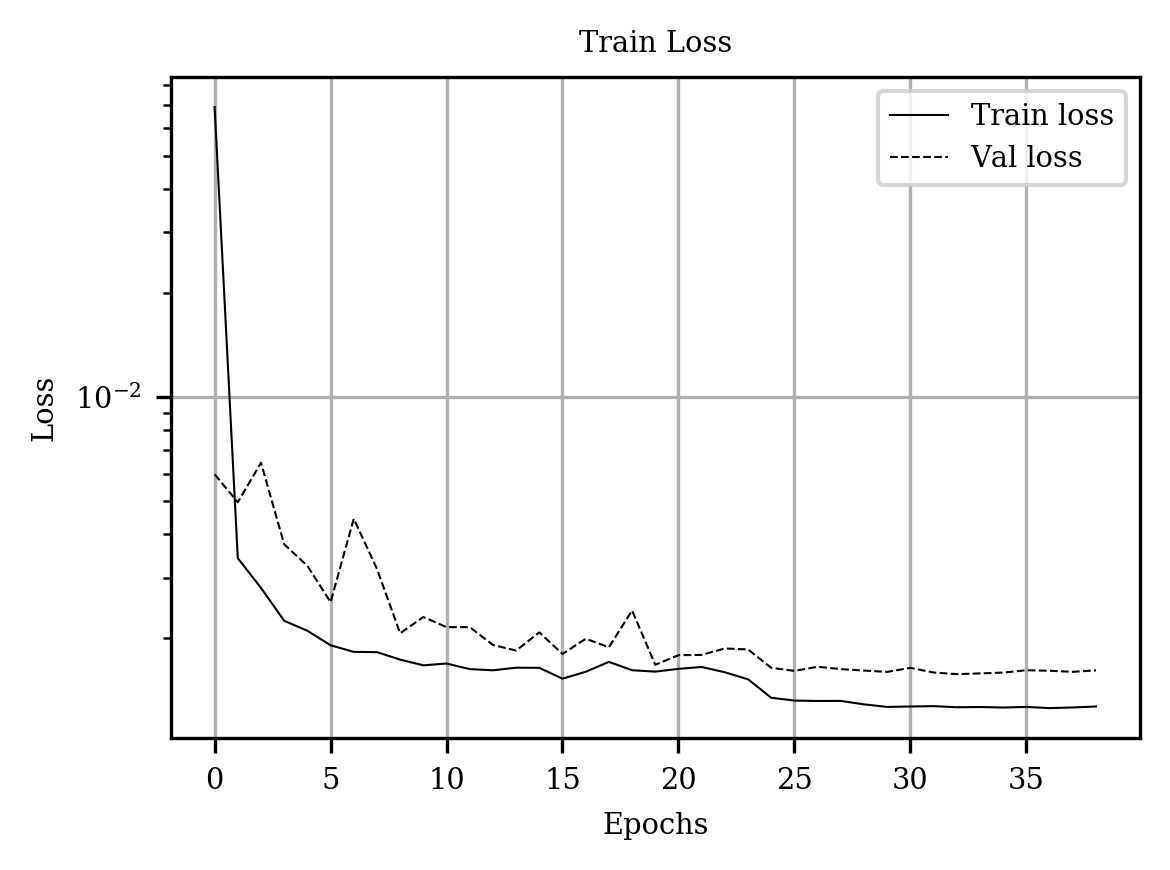

<Figure size 1200x900 with 0 Axes>

In [0]:
# Plot test and validation loss
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (4, 3)
plt.figure()
plt.semilogy(train_loss, 'k-', lw = 0.5)
plt.semilogy(val_loss, 'k--', lw = 0.5)
plt.xlabel("Epochs", fontsize = 'x-small')
plt.ylabel("Loss", fontsize = 'x-small')
plt.legend(['Train loss', 'Val loss'])
plt.grid(True)
plt.title('Train Loss', fontsize = 'x-small')
plt.tight_layout()
plt.show()
# plt.savefig("plots/train_loss_3.pdf", format = "pdf")

In [0]:
val_pred = model.predict(val_gen)

In [0]:
# predictions = pd.DataFrame(data = np.exp(val_log.iloc[lookback:, 0].values), index = val_log[lookback:].index, columns = ['True speed'])
# predictions["Predicted speed"] = np.exp(val_pred)
# predictions["Speed limit"] =  np.where(val.iloc[lookback:, val.columns.get_loc('speed_limit')] > 0.5, 130, 100)

In [0]:
predictions = pd.DataFrame(data = r_df.iloc[len(train) + lookback : -len(r_df[r_df.index > "2019-06"]) - 1, 0].values, index = val[lookback:].index, columns = ['True speed'])
# predictions = pd.DataFrame(data = val.iloc[lookback:, 0].values, index = val[lookback:].index, columns = ['True speed'])
fudge = val.copy()
fudge.iloc[lookback:, 0] = val_pred
predictions["Predicted speed"] = scaler.inverse_transform(fudge)[lookback:, 0]
predictions["Speed limit"] =  np.where(val.iloc[lookback:, val.columns.get_loc('speed_limit')] > 0.5, 130, 100)

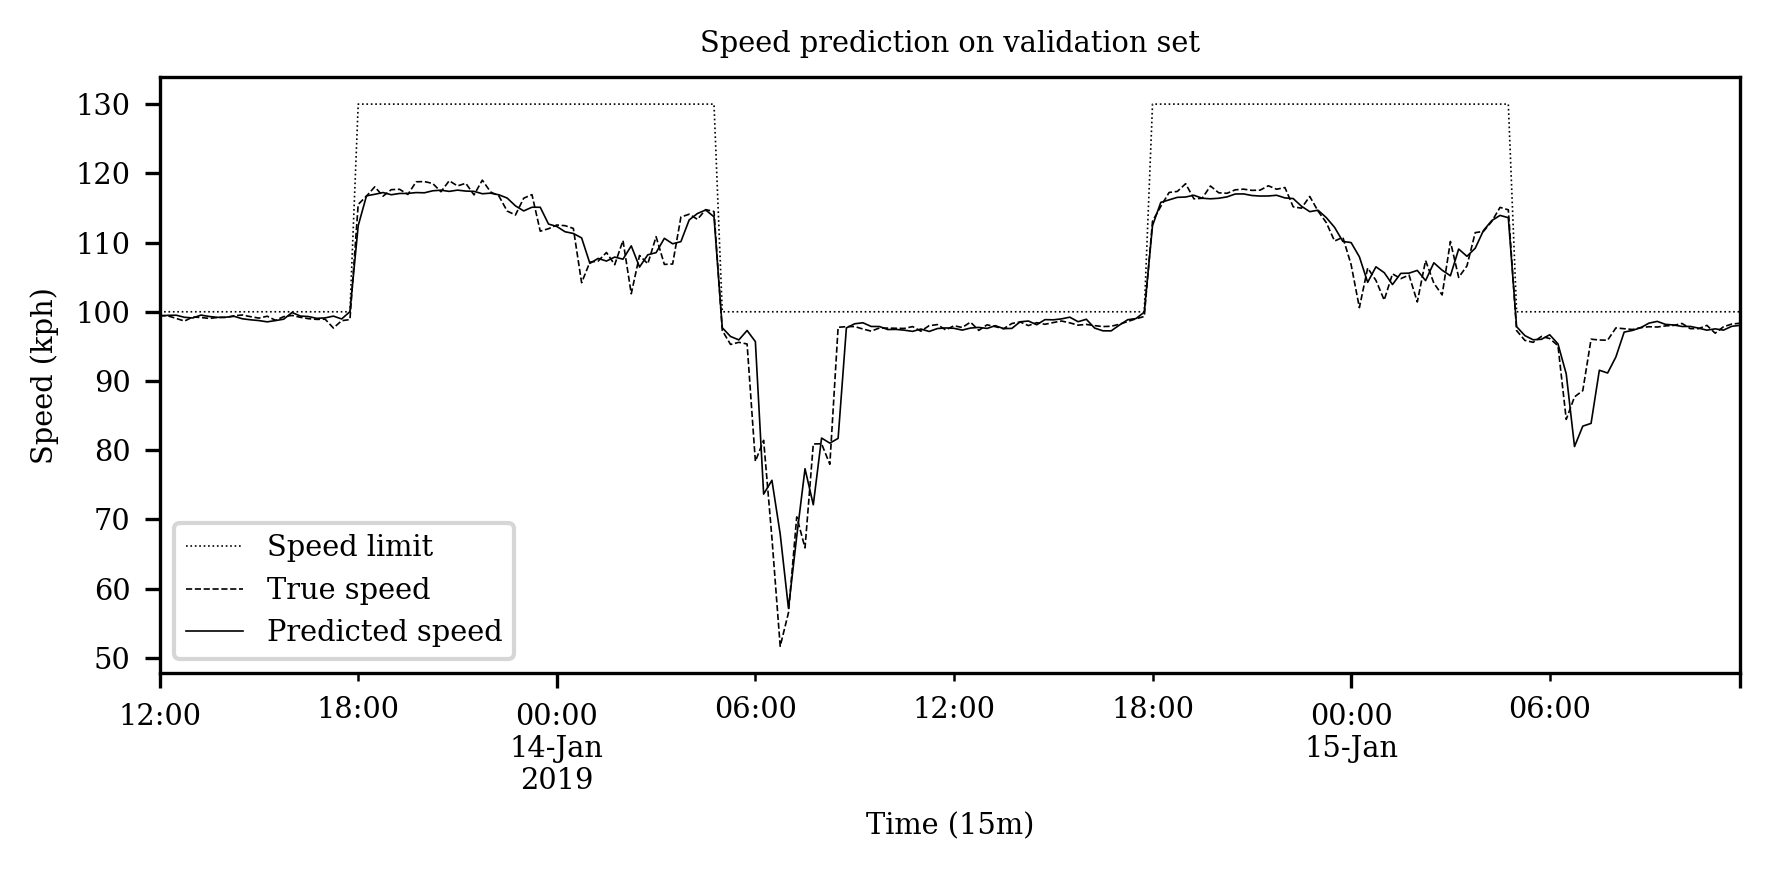

In [0]:
import matplotlib as mpl
start = 1104
end = 1296
y1 = predictions["Speed limit"]
y2 = predictions["True speed"]
y3 = predictions["Predicted speed"]
fig, ax = plt.subplots(figsize = (6, 3), sharey = True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
y1[start:end].plot(ax = ax, style = 'k:', lw = 0.4, label = "Speed limit")
y2[start:end].plot(ax = ax, style = 'k--', lw = 0.4, label = "True speed")
y3[start:end].plot(ax = ax, style = 'k-', lw = 0.4, label = "Predicted speed")
_, labels = ax.get_legend_handles_labels()
plt.legend(labels)
plt.title("Speed prediction on validation set", fontsize = 'x-small')
ax.set_xlabel('Time (15m)', fontsize = 'x-small')
ax.set_ylabel('Speed (kph)', fontsize = 'x-small')
plt.tight_layout()
# plt.savefig("plots/prediction_example_3.pdf", format = "pdf")

In [0]:
speed = predictions['True speed'].values
print(f"Naive MSE: {np.mean((speed[1:] - speed[:-1])**2)}")
print(f"Model MSE: {np.mean((predictions['True speed'] - predictions['Predicted speed'])**2)}")

Model R^2: 20.027088882785808
Naive R^2: 24.448094035079595


In [0]:
#Evaluate on test set
test_loss = model.evaluate(test_gen)
print('Test Loss: ' + str(test_loss))

In [0]:
    \hline
    Model run & Val $R^2$ & Test $R^2$\\
    \hline
    \#1 & $22.04$ & $14.81$ \\
    \hline
    \#2 & $20.03$ & $14.90$ \\
    \hline
    \#3 & $20.97$ & $14.63$ \\
    \hline
    Average & $21.01$ & $14.78$ \\
    \hline
    Naive & $24.45$ & $22.22$ \\
    \hline
    \end{tabular}
    \caption{Validation and test results.}
    \label{tab:R2}

In [0]:
import numpy as np
nums = [24.45, 22.22]
for num in nums:
    print(np.sqrt(num))

4.944694126030447
4.71380949975707


In [0]:
$24.45$ & $22.22$